# Import Libraries!

In [1]:
from sqlalchemy.orm import sessionmaker
import snowflake.connector
import redis
import pandas as pd
import matplotlib.pyplot as plt
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
from sqlalchemy import Column, Integer, String, Text, Float, TIMESTAMP
from sqlalchemy.ext.declarative import declarative_base
from snowflake.connector.pandas_tools import write_pandas


# Get environment variables

In [2]:
load_dotenv()

DATABASE_URL = os.getenv('DATABASE_URL')
REDIS_HOST = os.getenv('REDIS_HOST')
REDIS_PORT = int(os.getenv('REDIS_PORT'))
REDIS_USERNAME = os.getenv('REDIS_USERNAME')
REDIS_PASSWORD = os.getenv('REDIS_PASSWORD')
SNOWFLAKE_USER = os.getenv('SNOWFLAKE_USER')
SNOWFLAKE_PASSWORD = os.getenv('SNOWFLAKE_PASSWORD')
SNOWFLAKE_ACCOUNT = os.getenv('SNOWFLAKE_ACCOUNT')
SNOWFLAKE_WAREHOUSE = os.getenv('SNOWFLAKE_WAREHOUSE')
SNOWFLAKE_DATABASE = os.getenv('SNOWFLAKE_DATABASE')
SNOWFLAKE_SCHEMA = os.getenv('SNOWFLAKE_SCHEMA')

# OLTP setup

In [3]:
postgres_engine = create_engine(os.getenv("DATABASE_URL"))
with postgres_engine.connect() as conn:
    df_issues = pd.read_sql(text("SELECT * FROM urbanpulse.issue"), conn)
    df_votes = pd.read_sql(text("SELECT * FROM urbanpulse.vote"), conn)

print("Extracted issues:")
print(df_issues.head())
print("Extracted votes:")
print(df_votes.head())

Extracted issues:
   issue_id  citizen_id                    description        category  \
0         2           2  Public park needs maintenance     Environment   
1         4           1                        Issue 0  Infrastructure   
2         5           1                        Issue 1  Infrastructure   
3         6           1                        Issue 2  Infrastructure   
4         7           1                        Issue 3  Infrastructure   

   priority_level  latitude  longitude   status                 created_at  
0               3   40.7138    -74.007  Pending 2025-03-04 07:24:24.420805  
1               3   12.3400     56.780  Pending 2025-03-04 07:24:25.537125  
2               3   12.3400     56.780  Pending 2025-03-04 07:24:26.113725  
3               3   12.3400     56.780  Pending 2025-03-04 07:24:26.687319  
4               3   12.3400     56.780  Pending 2025-03-04 07:24:27.261736  
Extracted votes:
   vote_id  citizen_id  issue_id  priority_vote           

# Redis setup

In [4]:
r = redis.Redis(
    host=os.getenv("REDIS_HOST"),
    port=int(os.getenv("REDIS_PORT")),
    username=os.getenv("REDIS_USERNAME"),
    password=os.getenv("REDIS_PASSWORD"),
    decode_responses=True
)

# Snowflake setup

In [5]:
sf_conn = snowflake.connector.connect(
    user=SNOWFLAKE_USER,
    password=SNOWFLAKE_PASSWORD,
    account=SNOWFLAKE_ACCOUNT,
    warehouse=SNOWFLAKE_WAREHOUSE,
    database=SNOWFLAKE_DATABASE,
    schema=SNOWFLAKE_SCHEMA,
    ocsp_fail_open=False
)

sf_cursor = sf_conn.cursor()

In [6]:
# For demonstration, assume we have one urban issue and want to capture its vote count.
issue_key = "issue:" + df_issues.iloc[0]["issue_id"].__str__()
redis_votes = r.hget(issue_key + ":votes", "total_votes")
redis_votes = int(redis_votes) if redis_votes is not None else 0

In [7]:
# Create a DataFrame to hold Redis analytics data.
df_redis = pd.DataFrame([{"issue_id": df_issues.iloc[0]["issue_id"], "redis_votes": redis_votes}])
print("Extracted Redis votes:")
print(df_redis)

Extracted Redis votes:
   issue_id  redis_votes
0         2            0


In [8]:
# Create staging tables for issues and votes (if not exist)
create_issues_table = f"""
CREATE OR REPLACE TABLE issues_analytics (
    issue_id NUMBER,
    citizen_id NUMBER,
    description TEXT,
    category VARCHAR,
    priority_level NUMBER,
    latitude FLOAT,
    longitude FLOAT,
    status VARCHAR,
    created_at TIMESTAMP
)
"""
create_votes_table = f"""
CREATE OR REPLACE TABLE votes_analytics (
    vote_id NUMBER,
    citizen_id NUMBER,
    issue_id NUMBER,
    priority_vote NUMBER,
    created_at TIMESTAMP
)
"""

sf_cursor.execute("USE DATABASE SF_SAMPLE;")
sf_cursor.execute("USE SCHEMA urbanpulse;") 

sf_cursor.execute(create_issues_table)
sf_cursor.execute(create_votes_table)

In [9]:
# Load data from DataFrames into Snowflake tables using write_pandas
write_pandas(sf_conn, df_issues, "ISSUES_ANALYTICS", quote_identifiers=False)
write_pandas(sf_conn, df_votes, "VOTES_ANALYTICS", quote_identifiers=False)



(True,
 1,
 1012,
 [('afiqehqeil/file0.txt',
   'LOADED',
   1012,
   1012,
   1,
   0,
   None,
   None,
   None,
   None)])

# create table for redis

In [10]:
create_redis_votes_table = f"""
CREATE OR REPLACE TABLE redis_votes_analytics (
    issue_id NUMBER,
    redis_votes NUMBER
)
"""
sf_cursor.execute(create_redis_votes_table)
write_pandas(sf_conn, df_redis, "REDIS_VOTES_ANALYTICS", quote_identifiers=False)

sf_conn.commit()
print("Data loaded into Snowflake.")


Data loaded into Snowflake.


In [11]:
create_data_mart = f"""
CREATE OR REPLACE VIEW issues_summary AS
SELECT 
    i.issue_id,
    i.description,
    i.category,
    i.priority_level,
    i.status,
    COUNT(v.vote_id) AS total_votes_sql,
    COALESCE(r.redis_votes, 0) AS total_votes_redis,
    COUNT(v.vote_id) + COALESCE(r.redis_votes, 0) AS overall_votes
FROM issues_analytics i
LEFT JOIN votes_analytics v ON i.issue_id = v.issue_id
LEFT JOIN redis_votes_analytics r ON i.issue_id = r.issue_id
GROUP BY i.issue_id, i.description, i.category, i.priority_level, i.status, r.redis_votes
ORDER BY overall_votes DESC
"""
sf_cursor.execute(create_data_mart)
sf_conn.commit()
print("Analytical data mart (view) created.")


Analytical data mart (view) created.


/var/folders/q3/y9cmlg4s4xs988k0ck20g8cc0000gn/T/ipykernel_14193/3971034889.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_summary = pd.read_sql("SELECT * FROM issues_summary", sf_conn)


Analytics - Issues Summary:
      ISSUE_ID                    DESCRIPTION        CATEGORY  PRIORITY_LEVEL  \
0            1            Broken streetlights  Infrastructure               2   
1            2  Public park needs maintenance     Environment               3   
2           28                       Issue 12  Infrastructure               3   
3           30                       Issue 14  Infrastructure               3   
4           27                       Issue 11  Infrastructure               3   
...        ...                            ...             ...             ...   
1009       700                      Issue 684  Infrastructure               3   
1010       439                      Issue 423  Infrastructure               3   
1011       778                      Issue 762  Infrastructure               3   
1012       826                      Issue 810  Infrastructure               3   
1013       619                      Issue 603  Infrastructure               3   


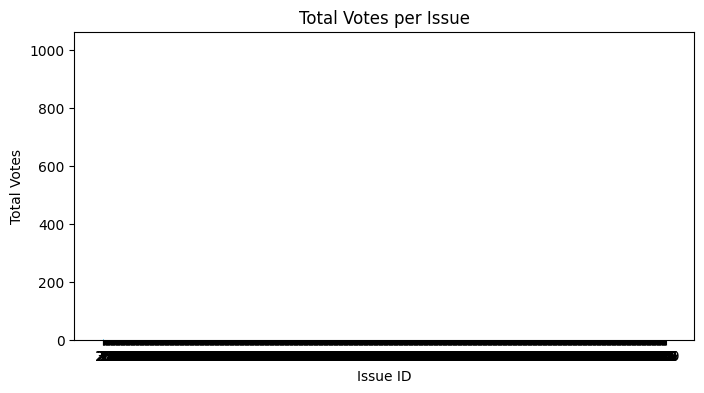

In [12]:
df_summary = pd.read_sql("SELECT * FROM issues_summary", sf_conn)
print("Analytics - Issues Summary:")
print(df_summary)

# Create a bar chart for overall votes per issue
plt.figure(figsize=(8, 4))
plt.bar(df_summary['ISSUE_ID'].astype(str), df_summary['OVERALL_VOTES'], color='skyblue')
plt.xlabel('Issue ID')
plt.ylabel('Total Votes')
plt.title('Total Votes per Issue')
plt.show()

In [13]:
print(df_issues.columns)


Index(['issue_id', 'citizen_id', 'description', 'category', 'priority_level',
       'latitude', 'longitude', 'status', 'created_at'],
      dtype='object')


In [14]:
# Simulate business change: Update status of one issue in PostgreSQL
with postgres_engine.connect() as conn:
    update_status_query = text("UPDATE urbanpulse.issue SET status = 'Completed' WHERE issue_id = :issue_id")

    issue_id = int(df_issues.iloc[0]["issue_id"])  # Convert to Python int

    conn.execute(update_status_query, {"issue_id": issue_id})  
    conn.commit()


print(f"Issue {df_issues.iloc[0]['issue_id']} status updated to 'Completed'.")

# Re-extract the changed issue data
with postgres_engine.connect() as conn:
    df_issues_updated = pd.read_sql(text("SELECT * FROM urbanpulse.issue"), conn)

# Reload updated issues data into Snowflake (overwrite the staging table)
write_pandas(sf_conn, df_issues_updated, "ISSUES_ANALYTICS", quote_identifiers=False)

# Re-create or refresh the analytical view
sf_cursor.execute(create_data_mart)
sf_conn.commit()

Issue 2 status updated to 'Completed'.


/var/folders/q3/y9cmlg4s4xs988k0ck20g8cc0000gn/T/ipykernel_14193/1178498516.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_summary_updated = pd.read_sql("SELECT * FROM issues_summary", sf_conn)


Updated Analytics - Issues Summary:
      ISSUE_ID                    DESCRIPTION        CATEGORY  PRIORITY_LEVEL  \
0            1            Broken streetlights  Infrastructure               2   
1            2  Public park needs maintenance     Environment               3   
2            2  Public park needs maintenance     Environment               3   
3           28                       Issue 12  Infrastructure               3   
4           26                       Issue 10  Infrastructure               3   
...        ...                            ...             ...             ...   
1010       439                      Issue 423  Infrastructure               3   
1011       778                      Issue 762  Infrastructure               3   
1012       826                      Issue 810  Infrastructure               3   
1013       619                      Issue 603  Infrastructure               3   
1014       691                      Issue 675  Infrastructure            

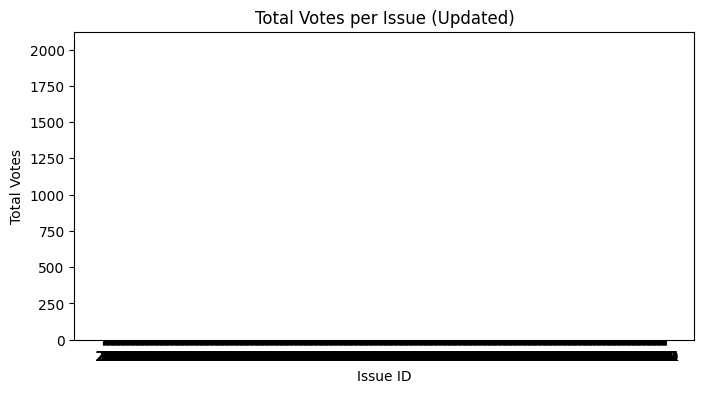

In [15]:
# ### 5.3 – Show Updated Analytics
#
# Query the refreshed view and show the updated chart.

# %% [code]
df_summary_updated = pd.read_sql("SELECT * FROM issues_summary", sf_conn)
print("Updated Analytics - Issues Summary:")
print(df_summary_updated)

# Create a bar chart for overall votes per issue after change
plt.figure(figsize=(8, 4))
# plt.bar(df_summary_updated['issue_id'].astype(str), df_summary_updated['overall_votes'], color='salmon')
plt.bar(df_summary_updated['ISSUE_ID'].astype(str), df_summary_updated['OVERALL_VOTES'], color='salmon')

plt.xlabel('Issue ID')
plt.ylabel('Total Votes')
plt.title('Total Votes per Issue (Updated)')
plt.show()

# Close Snowflake connection
sf_cursor.close()
sf_conn.close()